In [16]:
# TARNet (Baseline model) : A type of Deep Learning Model

In [17]:
# import packages

import tensorflow as tf
import numpy as np #numpy is the numerical computing package in python
import datetime    #we'll use dates to label our logs
print(tf.__version__)

2.9.2


In [18]:
# DataSet:
# The IHDP dataset used in this example is a naturalistic simulation introduced in Hill, 2011 to evaluate estimation of heterogeneous 
# treatment effects (CATE). The 25 covariates/features for the 747 units (139 treated) in the dataset were taken from an experiment, 
# but Hill simulated the outcomes to create known counterfactuals. The data is available from Fredrik Johansson's website. 
# IHDP is the de facto benchmark in this literature.

In [19]:
# Extracting Data:

from sklearn.preprocessing import StandardScaler
!wget -nc http://www.fredjo.com/files/ihdp_npci_1-100.train.npz
!wget -nc http://www.fredjo.com/files/ihdp_npci_1-100.test.npz 

File ‘ihdp_npci_1-100.train.npz’ already there; not retrieving.

File ‘ihdp_npci_1-100.test.npz’ already there; not retrieving.



In [20]:
# function for loading the data

def load_IHDP_data(training_data,testing_data,i=7):
    with open(training_data,'rb') as trf, open(testing_data,'rb') as tef:
        train_data=np.load(trf); test_data=np.load(tef)
        y=np.concatenate(   (train_data['yf'][:,i],   test_data['yf'][:,i])).astype('float32') #most GPUs only compute 32-bit floats
        t=np.concatenate(   (train_data['t'][:,i],    test_data['t'][:,i])).astype('float32')
        x=np.concatenate(   (train_data['x'][:,:,i],  test_data['x'][:,:,i]),axis=0).astype('float32')
        mu_0=np.concatenate((train_data['mu0'][:,i],  test_data['mu0'][:,i])).astype('float32')
        mu_1=np.concatenate((train_data['mu1'][:,i],  test_data['mu1'][:,i])).astype('float32')
 
        data={'x':x,'t':t,'y':y,'t':t,'mu_0':mu_0,'mu_1':mu_1}
        data['t']=data['t'].reshape(-1,1) #we're just padding one dimensional vectors with an additional dimension 
        data['y']=data['y'].reshape(-1,1)
        
        #rescaling y between 0 and 1 often makes training of DL regressors easier
        data['y_scaler'] = StandardScaler().fit(data['y'])
        data['ys'] = data['y_scaler'].transform(data['y'])
 
    return data
 
data=load_IHDP_data(training_data='./ihdp_npci_1-100.train.npz',testing_data='./ihdp_npci_1-100.test.npz')

In [21]:
# data is a dictionary (equivalent to a list in R). I'll print out a bit for you to see what it looks like:

for key in data:
  if key == 'y_scaler': continue
  print(key, data[key][:5])

x [[-0.65613806 -1.0024741  -0.360898    0.16170253  0.24605164 -0.8577868
   1.          0.          0.          0.          1.          0.
   0.          1.          1.          1.          0.          1.
   0.          0.          0.          0.          1.          0.
   0.        ]
 [-1.7153288  -1.0024741  -0.733261    0.16170253  1.1212925   0.9639847
   1.          0.          1.          0.          0.          1.
   0.          1.          1.          1.          1.          1.
   0.          0.          0.          0.          0.          0.
   0.        ]
 [ 0.5543657   0.19681813 -0.360898   -0.879606   -0.6917064  -1.0234023
   1.          0.          0.          1.          0.          0.
   0.          2.          0.          1.          0.          1.
   0.          0.          0.          0.          0.          1.
   0.        ]
 [ 0.53274953  0.5965822  -1.4779869   0.16170253  1.0587753  -0.8577868
   1.          0.          0.          1.          0.          0.
 

In [22]:
# import packages for DL model

from tensorflow import keras
from tensorflow.keras.layers import Input
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import Concatenate
from tensorflow.keras import regularizers
from tensorflow.keras import Model


In [23]:
# function to build the model using Tensorflow 2's functional API. The functional API is one of three API's in Tensorflow

def make_tarnet(input_dim, reg_l2):
    '''
    The first argument is the column dimension of our data.
    It needs to be specified because the functional API creates a static computational graph
    The second argument is the strength of regularization we'll apply to the output layers
    '''
    x = Input(shape=(input_dim,), name='input')

    # REPRESENTATION (no regularization to the representation layers)
    phi = Dense(units=200, activation='elu', kernel_initializer='RandomNormal',name='phi_1')(x)
    phi = Dense(units=200, activation='elu', kernel_initializer='RandomNormal',name='phi_2')(phi)
    phi = Dense(units=200, activation='elu', kernel_initializer='RandomNormal',name='phi_3')(phi)

    # HYPOTHESIS
    y0_hidden = Dense(units=100, activation='elu', kernel_regularizer=regularizers.l2(reg_l2),name='y0_hidden_1')(phi)
    y1_hidden = Dense(units=100, activation='elu', kernel_regularizer=regularizers.l2(reg_l2),name='y1_hidden_1')(phi)

    # second layer
    y0_hidden = Dense(units=100, activation='elu', kernel_regularizer=regularizers.l2(reg_l2),name='y0_hidden_2')(y0_hidden)
    y1_hidden = Dense(units=100, activation='elu', kernel_regularizer=regularizers.l2(reg_l2),name='y1_hidden_2')(y1_hidden)

    # third
    y0_predictions = Dense(units=1, activation=None, kernel_regularizer=regularizers.l2(reg_l2), name='y0_predictions')(y0_hidden)
    y1_predictions = Dense(units=1, activation=None, kernel_regularizer=regularizers.l2(reg_l2), name='y1_predictions')(y1_hidden)

    #a convenience "layer" that concatenates arrays as columns in a matrix
    concat_pred = Concatenate(1)([y0_predictions, y1_predictions])
    #the declarations above have specified the computational graph of our network, now we instantiate it
    model = Model(inputs=x, outputs=concat_pred)

    return model

Model: "model_1"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input (InputLayer)             [(None, 25)]         0           []                               
                                                                                                  
 phi_1 (Dense)                  (None, 200)          5200        ['input[0][0]']                  
                                                                                                  
 phi_2 (Dense)                  (None, 200)          40200       ['phi_1[0][0]']                  
                                                                                                  
 phi_3 (Dense)                  (None, 200)          40200       ['phi_2[0][0]']                  
                                                                                            

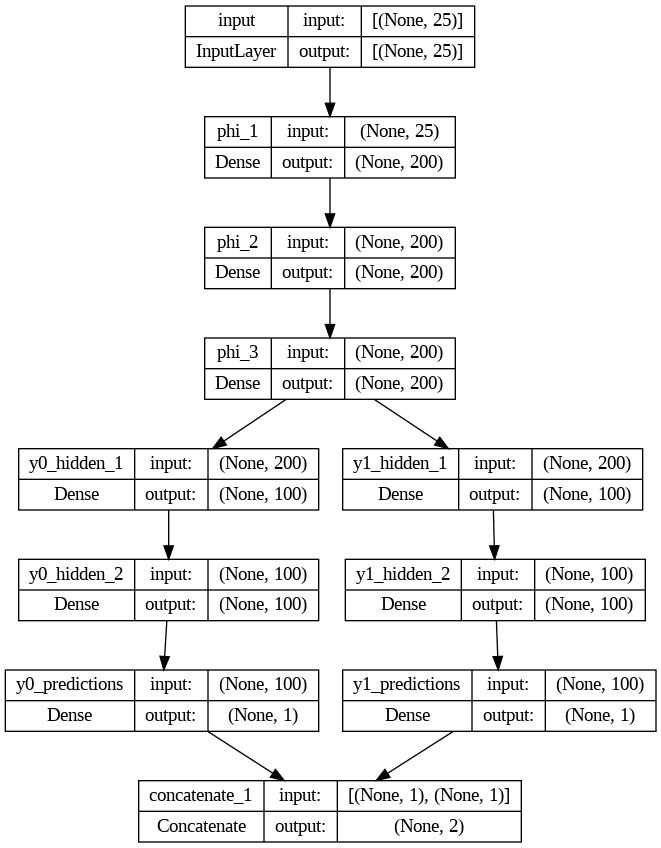

In [24]:
# The summary method can be used to confirm that the architecture is specified correctly.

tarnet_model=make_tarnet(25,.01)

print(tarnet_model.summary())
tf.keras.utils.plot_model(tarnet_model, show_shapes=True, show_layer_names=True, to_file='tarnet.png')

from IPython.display import Image             # this just Jupyter notebook stuff
Image(retina=True, filename='tarnet.png')     

In [25]:
# Specifying the loss function:
# There are again at least four different ways to specify loss functions in Tensorflow2: if you have a standard loss there are built-in options, 
# you can specify them as custom functions, custom objects, or build them into custom layers of your network. Here we've written a function.
# Note that we compute losses separately and just add them to get the whole loss. Tensorflow will apply the gradients appropriately to the 
# different outcome and representation layers.

In [26]:
# Specifying the loss function:

# every loss function in TF2 takes 2 arguments, a vector of true values and a vector predictions

def regression_loss(concat_true, concat_pred):
    #computes a standard MSE loss for TARNet
    y_true = concat_true[:, 0] #get individual vectors
    t_true = concat_true[:, 1]

    y0_pred = concat_pred[:, 0]
    y1_pred = concat_pred[:, 1]

    #Each head outputs a prediction for both potential outcomes
    #We use t_true as a switch to only calculate the factual loss

    loss0 = tf.reduce_sum((1. - t_true) * tf.square(y_true - y0_pred))
    loss1 = tf.reduce_sum(t_true * tf.square(y_true - y1_pred))
    
    return loss0 + loss1

In [27]:
# Training and Fitting the Model

# 1: used stochastic gradient descent to optimize the model with an initial learning rate, we can also use ADAM too
# 2: While we should experiment with different learning rates, I recommend having a conservative (smaller) learning rate because we really
#    want our estimator to be unbiased.
# 3: To avoid overfitting, we stop training deep learning models when the validation loss stops improving. In Tensorflow the EarlyStopping 
#    callback automatically stops training after a number of epochs with no improvement on the validation loss (patience parameter). 
#    The ReduceLROnPlateau adaptively lowers the learning rate of the optimizer as we approach validation loss plateaus so that the 
#    optimizer does not overshoot the current optimum.
# 4: Here used a mini-batch size of 64. We can also have batch sizes up to 200 with this dataset. 
#    The batch size is an important consideration for these causal inference architectures because you really want to make 
#    sure each mini-batch has both treatment and control examples for the representation layers. This is obviously less of a problem for 
#    datasets with high proportions of treated units.

In [28]:
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau, TerminateOnNaN
from tensorflow.keras.optimizers import SGD

val_split=0.2
batch_size=64
verbose=1
i = 0
tf.random.set_seed(i)
np.random.seed(i)
yt = np.concatenate([data['ys'], data['t']], 1) #we'll use both y and t to compute the loss


sgd_callbacks = [
        TerminateOnNaN(),
        EarlyStopping(monitor='val_loss', patience=40, min_delta=0.), 
        #40 is Shi's recommendation for this dataset, but you should tune for your data 
        ReduceLROnPlateau(monitor='loss', factor=0.5, patience=5, verbose=verbose, mode='auto',
                          min_delta=0., cooldown=0, min_lr=0),
    ]
#optimzier hyperparameters
sgd_lr = 1e-5
momentum = 0.9

In [29]:
tarnet_model.compile(optimizer=SGD(learning_rate=sgd_lr, momentum=momentum, nesterov=True),
                    loss=regression_loss,
                    metrics=regression_loss)

tarnet_model.fit(x=data['x'],y=yt,
                callbacks=sgd_callbacks,
                validation_split=val_split,
                epochs=300,
                batch_size=batch_size,
                verbose=verbose)
print("DONE!")

Epoch 1/300
10/10 [==============================] - 1s 28ms/step - loss: 59.7337 - regression_loss: 52.5815 - val_loss: 63.2503 - val_regression_loss: 52.3897 - lr: 1.0000e-05
Epoch 2/300
10/10 [==============================] - 0s 7ms/step - loss: 48.1597 - regression_loss: 42.3849 - val_loss: 53.6670 - val_regression_loss: 44.0304 - lr: 1.0000e-05
Epoch 3/300
10/10 [==============================] - 0s 5ms/step - loss: 40.3737 - regression_loss: 34.3807 - val_loss: 46.3316 - val_regression_loss: 37.5293 - lr: 1.0000e-05
Epoch 4/300
10/10 [==============================] - 0s 7ms/step - loss: 34.6918 - regression_loss: 28.8290 - val_loss: 41.4426 - val_regression_loss: 33.1405 - lr: 1.0000e-05
Epoch 5/300
10/10 [==============================] - 0s 6ms/step - loss: 31.5004 - regression_loss: 25.4943 - val_loss: 37.4112 - val_regression_loss: 29.5132 - lr: 1.0000e-05
Epoch 6/300
10/10 [==============================] - 0s 6ms/step - loss: 28.7955 - regression_loss: 22.8658 - val_loss:

In [30]:
# Since we know the true  CATEs in our simulations, let's plot our results against the true values..

import pandas as pd

def plot_cates(y0_pred,y1_pred,data):
  #dont forget to rescale the outcome before estimation!
  y0_pred = data['y_scaler'].inverse_transform(y0_pred)
  y1_pred = data['y_scaler'].inverse_transform(y1_pred)
  cate_pred=(y1_pred-y0_pred).squeeze()
  cate_true=(data['mu_1']-data['mu_0']).squeeze() #Hill's noiseless true values
  ate_pred=tf.reduce_mean(cate_pred)

  print(pd.Series(cate_pred).plot.kde(color='blue'))
  print(pd.Series(cate_true).plot.kde(color='green'))

  print(pd.Series(cate_true-cate_pred).plot.kde(color='red'))
  pehe=tf.reduce_mean( tf.square( ( cate_true - cate_pred) ) )
  sqrt_pehe=tf.sqrt(pehe).numpy()
  print("\nSQRT PEHE:",sqrt_pehe)
  print("Estimated ATE (True is 4):", ate_pred.numpy(),'\n\n')
  
  print("\nError CATE Estimates: RED")
  print("Individualized CATE Estimates: BLUE")
  print("Individualized CATE True: GREEN")
  return sqrt_pehe,np.abs(ate_pred.numpy()-4)

24/24 [==============================] - 0s 1ms/step
AxesSubplot(0.125,0.125;0.775x0.755)
AxesSubplot(0.125,0.125;0.775x0.755)
AxesSubplot(0.125,0.125;0.775x0.755)

SQRT PEHE: 0.6038055
Estimated ATE (True is 4): 3.7291324 



Error CATE Estimates: RED
Individualized CATE Estimates: BLUE
Individualized CATE True: GREEN


(0.6038055, 0.27086758613586426)

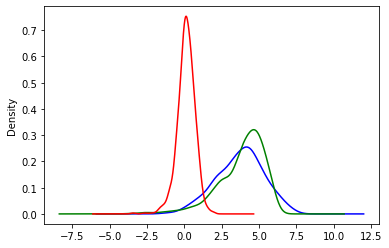

In [31]:
# Estimating the ATE/CATE

concat_pred=tarnet_model.predict(data['x'])
#dont forget to rescale the outcome before estimation!
y0_pred_tarnet,y1_pred_tarnet = (concat_pred[:, 0].reshape(-1,1)),(concat_pred[:, 1].reshape(-1,1))
plot_cates(y0_pred_tarnet,y1_pred_tarnet,data)

In [33]:
# # Load Facet Dive

# #@title Load Facet Dive { display-mode: "form" }
# cate_pred=(y1_pred_tarnet-y0_pred_tarnet).squeeze()
# data['cate_pred']=cate_pred
# facet_df=pd.DataFrame(data['x'])
# facet_df['t']=data['t']
# facet_df['y']=data['y']
# facet_df['cate_pred']=data['cate_pred']


# # Display the Dive visualization for the training data.
# from IPython.core.display import display, HTML

# jsonstr = facet_df.to_json(orient='records')
# HTML_TEMPLATE = """
#         <script src="https://cdnjs.cloudflare.com/ajax/libs/webcomponentsjs/1.3.3/webcomponents-lite.js"></script>
#         <link rel="import" href="https://raw.githubusercontent.com/PAIR-code/facets/1.0.0/facets-dist/facets-jupyter.html">
#         <facets-dive id="elem" height="600"></facets-dive>
#         <script>
#           var data = {jsonstr};
#           document.querySelector("#elem").data = data;
#         </script>"""
# html = HTML_TEMPLATE.format(jsonstr=jsonstr)
# display(HTML(html))

In [ ]:
# Save model : method 1:

In [37]:
# # save the Tarnet deep learning model using HDF5 standard
# # The '.h5' extension indicates that the model should be saved to HDF5.

# tarnet_model.save('Tarnet_model.h5')

In [38]:
# # Now, recreate the model from that file:
# # Recreate the exact same model, including its weights and the optimizer

# new_model = tensorflow.keras.models.load_model('Tarnet_model.h5')

In [39]:
# # Show the model architecture
# new_model.summary()

In [ ]:
# STEPS: Method 2:

In [ ]:
# # Calling `save('my_model')` creates a SavedModel folder `my_model`.
# model.save("my_model")
# # It can be used to reconstruct the model identically.
# reconstructed_model = keras.models.load_model("my_model")

# What the SavedModel contains:
# Calling model.save('my_model') creates a folder named my_model, containing the following:
# By using command the following files are visible :- ls my_model:
# assets  keras_metadata.pb  saved_model.pb  variables

# The model architecture, and training configuration (including the optimizer, losses, and metrics) are stored 
# in saved_model.pb. The weights are saved in the variables/ directory.

# For detailed information on the SavedModel format, see the SavedModel guide (The SavedModel format on disk).

# How SavedModel handles custom objects
# When saving the model and its layers, the SavedModel format stores the class name, call function, losses, and weights 
# (and the config, if implemented). The call function defines the computation graph of the model/layer.

# In the absence of the model/layer config, the call function is used to create a model that exists like the original model which 
# can be trained, evaluated, and used for inference.

# Nevertheless, it is always a good practice to define the get_config and from_config methods when writing a custom model or 
# layer class. This allows you to easily update the computation later if needed. See the section about Custom objects for more 
# information.

In [40]:
# tarnet_model.save("my_model")
# ls my_model

In [46]:
# Method 3:

In [47]:
# Saving the model 
# creating a new directory for model weights
import os
model_weight_dir = 'Weights'

os.makedirs(model_weight_dir, exist_ok = True)

# saving the model weights
tarnet_model.save(os.path.join(model_weight_dir,'tarnet_model.tf'),save_format ='tf')

In [50]:
# loading the save model
tarnet_load_model = tf.keras.models.load_model(os.path.join(model_weight_dir,'tarnet_model.tf'), compile=False) 

In [52]:
tarnet_load_model.summary()

Model: "model_1"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input (InputLayer)             [(None, 25)]         0           []                               
                                                                                                  
 phi_1 (Dense)                  (None, 200)          5200        ['input[0][0]']                  
                                                                                                  
 phi_2 (Dense)                  (None, 200)          40200       ['phi_1[0][0]']                  
                                                                                                  
 phi_3 (Dense)                  (None, 200)          40200       ['phi_2[0][0]']                  
                                                                                            

In [ ]:
# # Evaluation 
# evaluation = load_model.evaluate(x = x_ts, y = y_ts, batch_size = 512)

In [ ]:
# Total params: 146,202
# Trainable params: 146,202
# Non-trainable params: 0